**Input:** [mask$\times$Image; (1-mask)$\times$Image]

**Loss Function:** Weighted Loss

# Google Drive Mounting

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Generator

In [0]:
import numpy as np 
import matplotlib.pyplot as plt

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [0]:
import scipy.io         # for loading .mat ground truth files 
from PIL import Image   # for loading images to be resized 

In [0]:
eps = np.finfo(float).eps   # a small value, to avoid zero division

In [0]:
import scipy.ndimage as nd

def bwdist(mask):
    return nd.distance_transform_edt(np.logical_not(mask))

def mask2levelSet(mask):
    return bwdist(mask) - bwdist(1 - mask)

In [0]:
#!python generateMasks.py "/content/drive/My Drive/DeepLevelSet/train_images" "/content/drive/My Drive/DeepLevelSet/train_masks"

In [0]:
class Dataset(Dataset):
  def __init__(self, list_IDs):
        'Initialization'
        self.list_IDs = list_IDs
        self.base_url = "/content/drive/My Drive/DeepLevelSet"

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        ID = self.list_IDs[index]
        fileName = ID.split('.')[0]                                 # name without file extension  

        X_img = Image.open(f"{self.base_url}/train_images/{ID}")    # loading image
        X_img = X_img.resize((224, 224))                            # resizing to 224x224 
        X_img = np.asarray(X_img)                                   # PIL image to np.array
        
        X_mask_hat = np.load(f"{self.base_url}/train_masks/{fileName}.npy")
        X_mask = np.where(X_mask_hat==1, 0, 1)                          # inverting 1 and 0
        phi_init = mask2levelSet(X_mask).astype("float32")          # mask to level set
        phi_init_tensor = transforms.functional.to_tensor(phi_init) # converting to tensor 

        X_mask_hat = np.expand_dims(X_mask_hat, axis=-1)            # adding channel dim
        X_mask = np.expand_dims(X_mask, axis=-1)                    # adding channel dim

        X_mask_hat = np.dstack((X_mask_hat, X_mask_hat, X_mask_hat))  
        X_mask = np.dstack((X_mask, X_mask, X_mask))                    

        X_img_mask = (X_img * X_mask).astype("float32") 
        X_img_mask_hat = (X_img * X_img_mask).astype("float32") 

        X_img_mask = transforms.functional.to_tensor(X_img_mask)
        X_img_mask_hat = transforms.functional.to_tensor(X_img_mask_hat)


        X = torch.cat((X_img_mask, X_img_mask_hat), dim=0)         
        
        yMat = scipy.io.loadmat(f"{self.base_url}/groundTruth/{fileName}.mat")
        y = yMat['groundTruth'][0][0][0][0][0] - 1                  # fetching ground truth mask 
        y = Image.fromarray(y)                                      # converting to PIL image 
        y = y.resize((224, 224))                                    # resizing to 224x224
        y = np.asarray(y)                                           # converting back to array 
        phi_gt =  mask2levelSet(y).astype("float32")                # mask to level set

        Y = phi_init - phi_gt                                       # difference of levelsets 
        Y = Y / (np.abs(Y) + eps)                                   # normalizing 
        Y = transforms.functional.to_tensor(Y)                      # to tensor 
        Y = torch.squeeze(Y.view(-1, 1))                            # reshaping into a vector 

        return [X, phi_init_tensor], Y

# Model Definition

In [0]:
import torchvision.models as models

In [11]:
# loading pretrained resnet101
model = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [0]:
weight_conv1 = model.conv1.weight.clone()

In [0]:
# modifying first conv layer for 6 channel input
model.conv1 = torch.nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [0]:
with torch.no_grad():
    model.conv1.weight[:, :3] = weight_conv1
    model.conv1.weight[:, 3:] = weight_conv1

In [0]:
# modifying last layer 
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, out_features=224*224),
    torch.nn.Sigmoid()
)

In [0]:
# unfreezing model layers 
for name, param in model.named_parameters():
    try:
        param.requires_grad = True
    except Exception as e: 
        print(f"{name}: {e}")

In [0]:
# loading saved weights 
# BASE_URL = "/content/drive/My Drive/DeepLevelSet"
# model.load_state_dict(torch.load(f"{BASE_URL}/correct_Resnet.pth"))

In [17]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# moving model to GPU if available
model.to(device)

ResNet(
  (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Data Loader

In [0]:
import os

In [0]:
dirs = os.listdir("/content/drive/My Drive/DeepLevelSet/train_images")
partition = {
    'train': dirs
    }

In [0]:
params = {
    'batch_size': 32,
    'shuffle': True,
    'num_workers': 6
    }

training_set = Dataset(partition['train'])
training_generator = DataLoader(training_set, **params)

# Model Training 

In [0]:
from torch import optim

In [0]:
def weighted_loss(output, target, phi_init): 
    W = torch.where(phi_init < 1.2, torch.ones_like(phi_init), torch.zeros_like(phi_init))
    W = W.view(W.shape[0], -1) # W.shape[0] = batch_size

    squared_error = torch.nn.MSELoss(reduction='none')(output, target) # (output - target)**2
    loss = torch.mean(W * squared_error)

    return loss

In [0]:
optimizer = torch.optim.Adam(params=model.parameters()) 

In [24]:
epochs = 200

train_losses = []
for e in range(epochs):
    running_loss = 0
    for local_batch, local_labels in training_generator:
        local_inputs, local_phi_init = local_batch[0], local_batch[1]
        inputs, phi_init, labels = local_inputs.to(device), local_phi_init.to(device), local_labels.to(device)
        F = model(inputs)
        loss = weighted_loss(2*F-1, labels, phi_init)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss/len(training_generator))

    print(f"Epoch: {e+1}/{epochs}.. Training Loss: {running_loss/len(training_generator):.4f}")

Epoch: 1/200.. Training Loss: 0.1470
Epoch: 2/200.. Training Loss: 0.1369
Epoch: 3/200.. Training Loss: 0.1305
Epoch: 4/200.. Training Loss: 0.1301
Epoch: 5/200.. Training Loss: 0.1268
Epoch: 6/200.. Training Loss: 0.1277
Epoch: 7/200.. Training Loss: 0.1238
Epoch: 8/200.. Training Loss: 0.1224
Epoch: 9/200.. Training Loss: 0.1171
Epoch: 10/200.. Training Loss: 0.1164
Epoch: 11/200.. Training Loss: 0.1119
Epoch: 12/200.. Training Loss: 0.1065
Epoch: 13/200.. Training Loss: 0.1067
Epoch: 14/200.. Training Loss: 0.1033
Epoch: 15/200.. Training Loss: 0.1015
Epoch: 16/200.. Training Loss: 0.1004
Epoch: 17/200.. Training Loss: 0.1008
Epoch: 18/200.. Training Loss: 0.0982
Epoch: 19/200.. Training Loss: 0.0955
Epoch: 20/200.. Training Loss: 0.0941
Epoch: 21/200.. Training Loss: 0.0964
Epoch: 22/200.. Training Loss: 0.0953
Epoch: 23/200.. Training Loss: 0.0945
Epoch: 24/200.. Training Loss: 0.0891
Epoch: 25/200.. Training Loss: 0.0865
Epoch: 26/200.. Training Loss: 0.0849
Epoch: 27/200.. Train

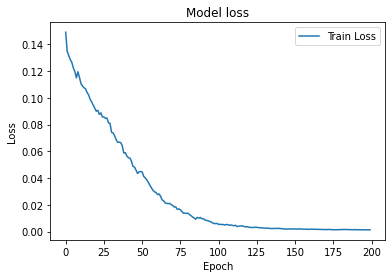

In [0]:
plt.plot(train_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'])
plt.show()

In [0]:
# saving model 
BASE_URL = "/content/drive/My Drive/DeepLevelSet"
torch.save(model.state_dict(), f"{BASE_URL}/ResNet_mask_WL.pth" )

# Model Testing

In [0]:
BASE_URL = "/content/drive/My Drive/DeepLevelSet"

In [0]:
def test_preprocess(X_img, mask): 
    mask_hat = np.where(mask==1, 0, 1) 

    X_mask_hat = np.expand_dims(mask_hat, axis=-1)              # adding channel dim
    X_mask = np.expand_dims(mask, axis=-1)                      # adding channel dim

    X_mask_hat = np.dstack((X_mask_hat, X_mask_hat, X_mask_hat))  
    X_mask = np.dstack((X_mask, X_mask, X_mask))   

    X_img_mask = (X_img * X_mask).astype("float32") 
    X_img_mask_hat = (X_img * X_img_mask).astype("float32") 

    X_img_mask = transforms.functional.to_tensor(X_img_mask)
    X_img_mask_hat = transforms.functional.to_tensor(X_img_mask_hat)

    X = torch.cat((X_img_mask, X_img_mask_hat), dim=0) 

    return X

In [0]:
def get_prediction(img, mask): 
    with torch.no_grad():
        model.eval()

        # preperaing model input 
        X = test_preprocess(img, mask)
        X = X.unsqueeze(0)
        X = X.to(device)
        
        # getting model prediction 
        F = 2*model(X)-1
        F = F.view(224, 224)
        F = F.cpu().numpy()

        return F

In [0]:
def get_target(ID, phi_init):
    yMat = scipy.io.loadmat(f"{BASE_URL}/groundTruth/{ID}.mat")
    y = yMat['groundTruth'][0][0][0][0][0] - 1                  # fetching ground truth mask 
    y = Image.fromarray(y)                                      # converting to PIL image 
    y = y.resize((224, 224))                                    # resizing to 224x224
    y = np.asarray(y)                                           # converting back to array 
    phi_gt =  mask2levelSet(y).astype("float32")                # mask to level set

    Y = phi_init - phi_gt                                       # difference of levelsets 
    Y = Y / (np.abs(Y) + eps)                                   # normalizing 

    return Y 

In [0]:
def plot_pred(ID):
    # reading image 
    X_img = Image.open(f"{BASE_URL}/train_images/{ID}.jpg")     # loading image
    X_img = X_img.resize((224, 224))                            # resizing to 224x224

    # reading initialization mask
    mask_init = np.load(f"{BASE_URL}/train_masks/{ID}.npy")
    mask_init = np.where(mask_init==1, 0, 1)
    phi = mask2levelSet(mask_init)                              # mask to phi 

    # getting target 
    Y = get_target(ID, phi)

    # getting model prediction 
    F = get_prediction(X_img, mask_init)

    # plotting results 
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1).set_title("Image")
    plt.imshow(X_img, cmap='gray')

    plt.subplot(2, 2, 2).set_title("Init LS")
    plt.imshow(phi, cmap='gray')

    plt.subplot(2, 2, 3).set_title("Model Predicton")
    plt.imshow(F, cmap='gray')

    plt.subplot(2, 2, 4).set_title("Target")
    plt.imshow(Y, cmap='gray')


    # adding padding between two figures 
    plt.subplots_adjust(hspace = 0.5)

    # displaying figure
    plt.show()

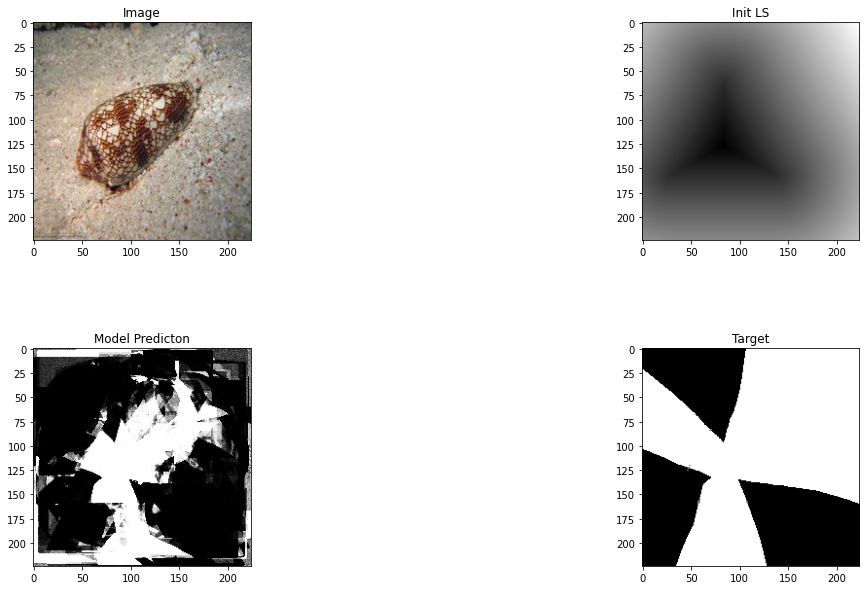

In [46]:
plot_pred(1)

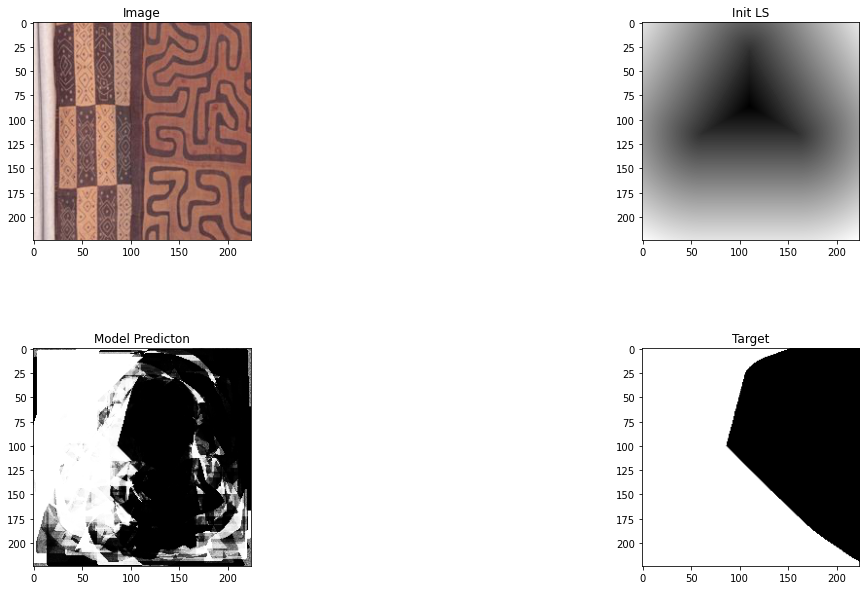

In [47]:
plot_pred(2)

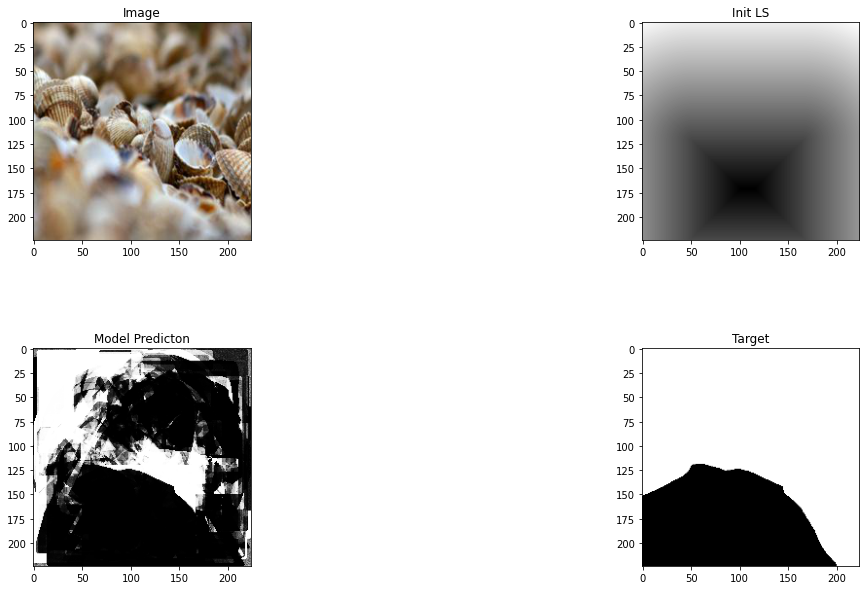

In [48]:
plot_pred(3)

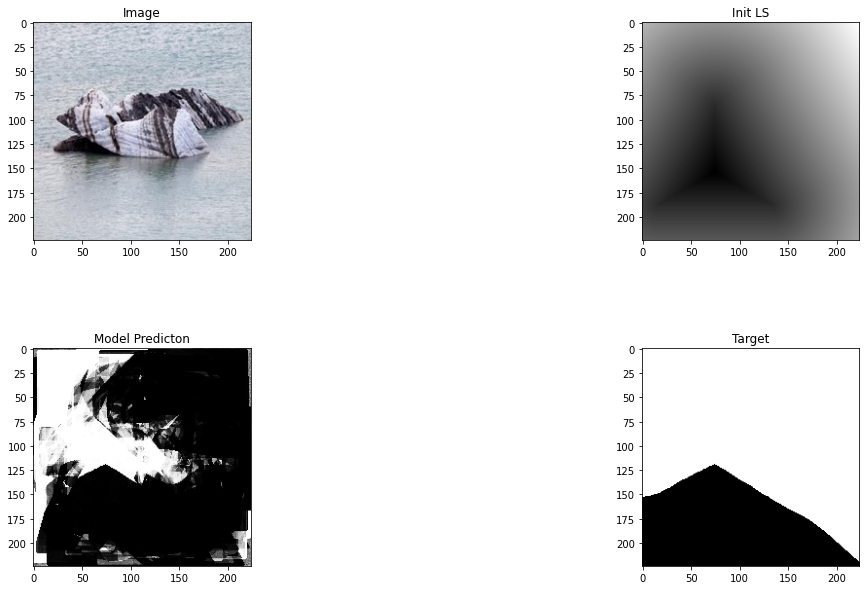

In [49]:
plot_pred(4)

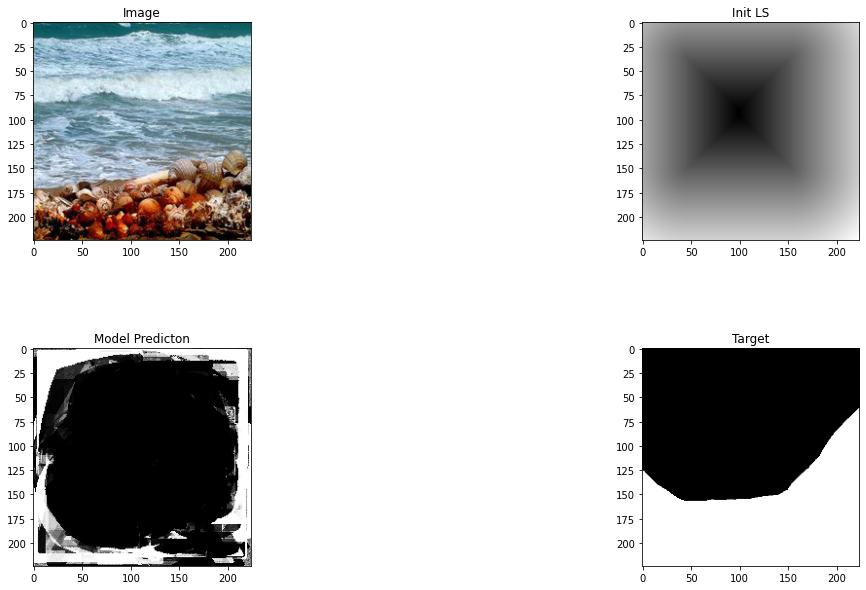

In [50]:
plot_pred(5)